In [165]:
import sys
import importlib
from tqdm import tqdm, trange
sys.path.append("../src")

import pseudobulk
importlib.reload(pseudobulk)
import models
importlib.reload(models)
import utils
importlib.reload(utils)

<module 'utils' from '/home/jhaberbe/Projects/Personal/bulk-deconvolution/notebook/../src/utils.py'>

In [3]:
import scanpy as sc

pbulk = sc.read_h5ad(
    "/home/jhaberbe/Projects/Personal/bulk-deconvolution/data/pbulk.h5ad"
)

# Maybe exclude subset
sc.pp.highly_variable_genes(pbulk, flavor="seurat_v3", subset=True)

# Training the mixture model

In [4]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, random_split

X_raw = torch.tensor(pbulk.X, dtype=torch.float32)  # (n, F), convert from sparse
y = torch.tensor(pbulk.obs.values, dtype=torch.float32)
y = y / y.sum(dim=1, keepdim=True).clamp(min=1e-8)  # Normalize rows

X = utils.scanpy_log_normalize(X_raw)

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

mixture_model = models.MixturePrediction(X, y)

In [24]:
import torch.nn.functional as F

optimizer = torch.optim.Adam(mixture_model.parameters(), lr=1e-3)

# --- Training loop ---
epochs = 50
for epoch in range(epochs):
    mixture_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = mixture_model(xb)
        loss = F.kl_div(preds.log(), yb, reduction='batchmean')
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Evaluate on test
    mixture_model.eval()
    with torch.no_grad():
        test_loss = 0
        for xb, yb in test_loader:
            preds = mixture_model(xb)
            test_loss += F.kl_div(preds.log(), yb, reduction='batchmean').item()

    print(f"Epoch {epoch:02d} | Train Loss: {total_loss:.4f} | Test Loss: {test_loss:.4f}")

Epoch 00 | Train Loss: 39.8297 | Test Loss: 1.7247
Epoch 01 | Train Loss: 11.4133 | Test Loss: 1.2601
Epoch 02 | Train Loss: 8.2495 | Test Loss: 1.0629
Epoch 03 | Train Loss: 7.2971 | Test Loss: 0.8544
Epoch 04 | Train Loss: 6.2426 | Test Loss: 0.7956
Epoch 05 | Train Loss: 5.4839 | Test Loss: 0.6319
Epoch 06 | Train Loss: 4.8126 | Test Loss: 0.6221
Epoch 07 | Train Loss: 4.5027 | Test Loss: 0.5177
Epoch 08 | Train Loss: 3.9968 | Test Loss: 0.5271
Epoch 09 | Train Loss: 3.7191 | Test Loss: 0.4592
Epoch 10 | Train Loss: 3.4107 | Test Loss: 0.4445
Epoch 11 | Train Loss: 3.3774 | Test Loss: 0.4286
Epoch 12 | Train Loss: 3.0473 | Test Loss: 0.4444
Epoch 13 | Train Loss: 3.0061 | Test Loss: 0.3754
Epoch 14 | Train Loss: 2.8171 | Test Loss: 0.3558
Epoch 15 | Train Loss: 2.8839 | Test Loss: 0.3505
Epoch 16 | Train Loss: 2.8389 | Test Loss: 0.4110
Epoch 17 | Train Loss: 2.7281 | Test Loss: 0.3439
Epoch 18 | Train Loss: 2.6644 | Test Loss: 0.3423
Epoch 19 | Train Loss: 2.7263 | Test Loss: 0.442

In [5]:
# torch.save(mixture_model, "../models/mixture_model.pt")
mixture_model = torch.load("../models/mixture_model.pt", weights_only=False)

# Training Dirichlet Model

In [64]:
mixture_weights = mixture_model(X)
mixture_weights = mixture_weights.detach()

In [ ]:
dirichlet_model = models.MixtureToDirichlet(num_components=8, num_features=X.shape[1]).to("cuda")

In [75]:
import numpy as np
counts = torch.tensor(np.stack([pbulk.layers[layer] for layer in pbulk.layers if layer in pbulk.obs.columns])).permute(1, 0, 2)

In [176]:
from torch import nn

class MixtureToDirichlet(nn.Module):
    def __init__(self, num_components, num_features, hidden_dim=128):
        super().__init__()
        self.num_components = num_components
        self.num_features = num_features

        # MLP will process concatenated (pi, X)
        self.fc1 = nn.Linear(num_components + num_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_components * num_features)

    def forward(self, pi, X):
        """
        Args:
            pi: [n, C] - mixture weights per sample
            X:  [n, F] - observed total gene expression per sample
        Returns:
            alpha: [n, C, F] - Dirichlet parameters
        """
        x = torch.cat([pi, X], dim=1)        # [n, C + F]
        x = F.relu(self.fc1(x))              # [n, hidden_dim]
        x = self.fc2(x).view(-1, self.num_components, self.num_features)  # [n, C, F]
        alpha = F.softplus(x) + 1e-3         # ensure positivity
        return alpha

    @staticmethod
    def dirichlet_multinomial_loss(alpha, counts):
        """
        Args:
            alpha: [n, C, F] - predicted Dirichlet params
            counts: [n, C, F] - observed counts per component per feature
        Returns:
            scalar - Negative log-likelihood
        """
        n, C, F = counts.shape

        # Flatten over (n, f)
        alpha_flat = alpha.permute(0, 2, 1).reshape(-1, C)   # [n * F, C]
        counts_flat = counts.permute(0, 2, 1).reshape(-1, C) # [n * F, C]
        total_count = counts_flat.sum(dim=1)                # [n * F]

        dist = DirichletMultinomial(total_count=total_count, concentration=alpha_flat)
        return -dist.log_prob(counts_flat).mean()


In [ ]:
import torch.nn.functional as F
from pyro.distributions import DirichletMultinomial
from torch.utils.data import TensorDataset, DataLoader

# Normalize expression (shape: [n, F])
expression = utils.scanpy_log_normalize(counts.sum(dim=1)).to("cuda")  # [n, F]

# Create dataset and dataloader
batch_size = pbulk.shape[0]
dataset = TensorDataset(mixture_weights, expression, counts)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = MixtureToDirichlet(num_components=counts.shape[1], num_features=counts.shape[2]).to("cuda")

Epoch 0 | Loss: 19.7728
Epoch 1 | Loss: 28.3131
Epoch 2 | Loss: 17.7597
Epoch 3 | Loss: 18.8511
Epoch 4 | Loss: 18.4046
Epoch 5 | Loss: 17.4655
Epoch 6 | Loss: 16.8433
Epoch 7 | Loss: 15.9329
Epoch 8 | Loss: 15.6295
Epoch 9 | Loss: 14.9699
Epoch 10 | Loss: 14.9670
Epoch 11 | Loss: 14.7432
Epoch 12 | Loss: 14.6291
Epoch 13 | Loss: 14.7144
Epoch 14 | Loss: 14.4560
Epoch 15 | Loss: 14.6280
Epoch 16 | Loss: 14.4437
Epoch 17 | Loss: 14.4187
Epoch 18 | Loss: 14.5736
Epoch 19 | Loss: 14.3503
Epoch 20 | Loss: 14.4034
Epoch 21 | Loss: 14.5914
Epoch 22 | Loss: 14.3264
Epoch 23 | Loss: 14.3394
Epoch 24 | Loss: 14.4730
Epoch 25 | Loss: 14.2411
Epoch 26 | Loss: 14.3133
Epoch 27 | Loss: 14.3952


KeyboardInterrupt: 

In [199]:

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(10_000):
    model.train()
    epoch_loss = 0.0

    for batch_mixture, batch_expr, batch_counts in loader:
        batch_mixture = batch_mixture.to("cuda")  # [b, C]
        batch_expr = batch_expr.to("cuda")        # [b, F]
        batch_counts = batch_counts.to("cuda")    # [b, C, F]

        optimizer.zero_grad()
        alpha_pred = model(batch_mixture, batch_expr)  # [b, C, F]
        loss = model.dirichlet_multinomial_loss(alpha_pred, batch_counts)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    print(f"Epoch {epoch} | Loss: {avg_loss:.4f}")


Epoch 0 | Loss: 13.9224
Epoch 1 | Loss: 14.3309
Epoch 2 | Loss: 13.9265
Epoch 3 | Loss: 14.0106
Epoch 4 | Loss: 14.1327
Epoch 5 | Loss: 14.0529
Epoch 6 | Loss: 13.9217
Epoch 7 | Loss: 13.8793
Epoch 8 | Loss: 13.9334
Epoch 9 | Loss: 13.9793
Epoch 10 | Loss: 13.9540
Epoch 11 | Loss: 13.8892
Epoch 12 | Loss: 13.8453
Epoch 13 | Loss: 13.8485
Epoch 14 | Loss: 13.8745
Epoch 15 | Loss: 13.8833
Epoch 16 | Loss: 13.8610
Epoch 17 | Loss: 13.8251
Epoch 18 | Loss: 13.8021
Epoch 19 | Loss: 13.8023
Epoch 20 | Loss: 13.8129
Epoch 21 | Loss: 13.8136
Epoch 22 | Loss: 13.7974
Epoch 23 | Loss: 13.7748
Epoch 24 | Loss: 13.7600
Epoch 25 | Loss: 13.7574
Epoch 26 | Loss: 13.7594
Epoch 27 | Loss: 13.7555
Epoch 28 | Loss: 13.7430
Epoch 29 | Loss: 13.7277
Epoch 30 | Loss: 13.7171
Epoch 31 | Loss: 13.7130
Epoch 32 | Loss: 13.7109
Epoch 33 | Loss: 13.7050
Epoch 34 | Loss: 13.6944
Epoch 35 | Loss: 13.6828
Epoch 36 | Loss: 13.6743
Epoch 37 | Loss: 13.6693
Epoch 38 | Loss: 13.6648
Epoch 39 | Loss: 13.6577
Epoch 40 |

KeyboardInterrupt: 

In [200]:
torch.save(dirichlet_model, "../models/dirichlet_expr_model.pt")
# dirichlet_model = torch.load("../models/dirichlet_model.pt", weights_only=False)

PicklingError: Can't pickle <class 'models.MixtureToDirichlet'>: it's not the same object as models.MixtureToDirichlet

# Output

In [201]:
def dirichlet_mle_counts(alpha: torch.Tensor, total_counts: torch.Tensor) -> torch.Tensor:
    """
    Args:
        alpha: [n, C, F] - Dirichlet concentration parameters
        total_counts: [n, F] - observed total counts per feature per sample

    Returns:
        estimated_counts: [n, C, F] - MLE count split per component
    """
    # Dirichlet mean
    alpha_sum = alpha.sum(dim=1, keepdim=True)  # [n, 1, F]
    probs = alpha / alpha_sum  # [n, C, F]

    # Broadcast total counts across components
    estimated_counts = probs * total_counts.unsqueeze(1)  # [n, C, F]
    return estimated_counts

layer_counts = dirichlet_mle_counts(
    dirichlet_model(batch_mixture),
    total_counts=torch.tensor(pbulk.X).to("cuda")
    )

In [202]:
for i, layer in enumerate(pbulk.obs.columns):
    pbulk.layers["predicted " + layer] = layer_counts[:, i, :].cpu().detach().numpy()
    pbulk.layers["alpha " + layer] = dirichlet_model(batch_mixture)[:, i, :].cpu().detach().numpy()

In [203]:
for layer in pbulk.layers:
    print(pbulk.layers[layer][0, 200])

0.0
33.0
1.0
1.0
40.0
0.0
494.0
26.0
25.491549
17.358498
140.35297
17.338182
133.17232
95.87957
133.64352
31.763393
0.37315482
0.25410017
2.0545392
0.2538028
1.949426
1.403521
1.9563239
0.4649644


<Axes: xlabel='x', ylabel='y'>

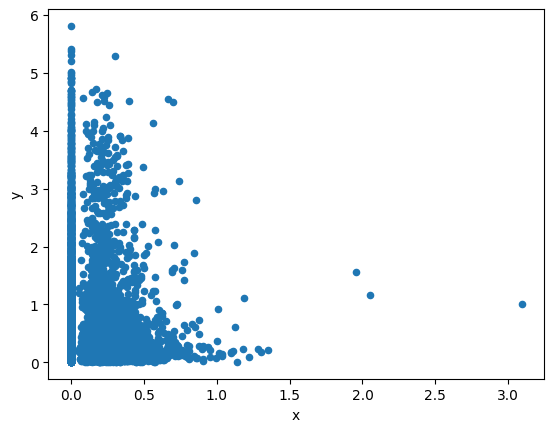

In [210]:
import pandas as pd
pd.DataFrame({
    "x": pbulk.layers["astrocyte"][:, 1],
    "y": pbulk.layers["alpha astrocyte"][:, 1]
}).plot.scatter("x", "y")

# Testing

/home/jhaberbe/Projects/Personal/bulk-deconvolution/.venv/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)


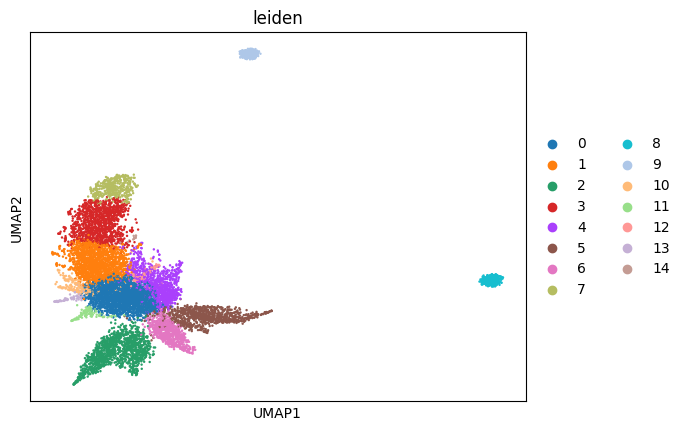

In [220]:
import anndata as ad

testing = ad.AnnData(
    X=pbulk.layers["fibroblast"]
)
sc.pp.normalize_total(testing)
sc.pp.log1p(testing)
sc.pp.pca(testing)
sc.pp.neighbors(testing)
sc.tl.leiden(testing)
sc.tl.umap(testing)
sc.pl.umap(testing, color=["leiden"])

/tmp/ipykernel_1527556/3050251834.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  testing.obs["leiden"] = leiden


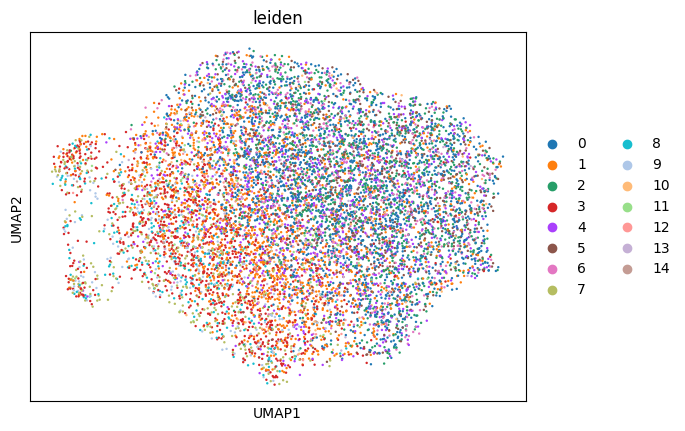

In [225]:
import anndata as ad

leiden = testing.obs["leiden"]
testing = ad.AnnData(
    X=pbulk.layers["predicted fibroblast"]
)
testing = testing[:, pbulk.layers["alpha fibroblast"].mean(axis=0) > 5]
testing.obs["leiden"] = leiden
sc.pp.normalize_total(testing)
sc.pp.log1p(testing)
sc.pp.pca(testing)
sc.pp.neighbors(testing)
sc.tl.umap(testing)
sc.pl.umap(testing, color="leiden")

np.float64(1.6502773940563198)